In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing 
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

##  Goal

The notebook demonstrates 3 usecases for implementing models by instructing it how to arrive at the output


In [3]:
def print_results(result, X_train, y_train, X_test, y_test):
     
    """
    The function takes in a fitted model and training and test data and prints the best params and training and test set performance 
    """
    
    print("XGB Model best params : {}".format(result.best_params_))
    
    ypred_train = result.predict(X_train)
    mse_train = mean_squared_error(y_train, ypred_train)
    print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
    ypred_test = result.predict(X_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

In [4]:
def get_partial_dependence(res, feature, X, y):
    """
    The function takes in a fitted model, data and a feature of X and takes a sample of 50 feature values called grid and
    calculates partial dependence.The partial function tells us for given value(s) of feature what is the average 
    marginal effect on the model prediction
    """
    data = X.copy()
    grid = np.linspace(np.percentile(data.loc[:, feature], 0.1),
                       np.percentile(data.loc[:, feature], 99.5),
                    50)
    y_pred = np.zeros(50)
    for i, val in enumerate(grid):
                data.loc[:, feature] = val
                pred = res.predict(data)
                y_pred[i] = np.average(pred)
    
    return grid, y_pred

## Usecase 1: The model prediction must not be too sensitive to x3

An example for implementing this usecase is the Boston Housing toy dataset imported from sklearn datasets. It has 506 rows and 13 attributes.To implement use case 3  we will create two XGBoost models. The first model will be trained on the whole dataset and the second will be trained on a subset of the dataset.The final prediction will be a weighted average of these two models. 

In [5]:
boston_dataset = load_boston()
print(boston_dataset.keys())

dict_keys(['filename', 'DESCR', 'data', 'target', 'feature_names'])


In [6]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.drop(columns=['B', 'LSTAT'], inplace=True)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,36.2


## USE CASE 1 - Monotone Constraint

#### CV MODEL WITH NO CONSTRAINTS

In [7]:
X, y = boston.iloc[:,:-1], boston.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [8]:
param_grid = {
                'max_depth': [3], 
                'learning_rate': [.05], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [25, 30, 40, 50, 100, 150],
                'reg_gamma': [0.5]
}

model_2 = xgb.XGBRegressor()
gr = GridSearchCV(model_2,param_grid=param_grid,cv=5, verbose=True)
model_2_boston = gr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.2s finished


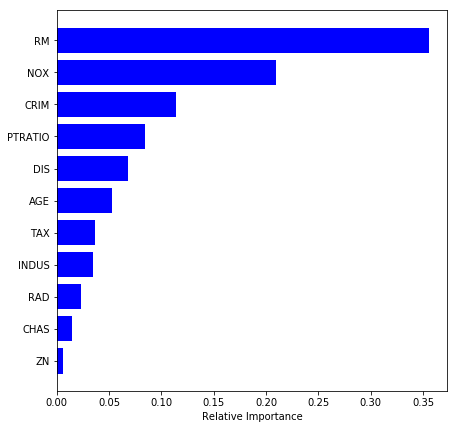

In [9]:
features = X_train.columns
importances = model_2_boston.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Text(0, 0.5, 'Prediction')

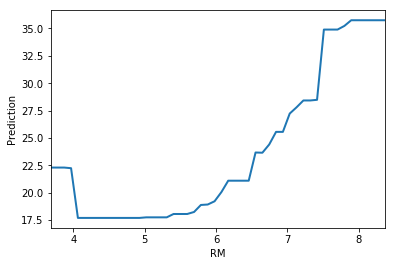

In [10]:
fig, ax = plt.subplots(1,1)
grid, y_pred = get_partial_dependence(model_2_boston, 'RM', X_train, y_train)
axis = ax
axis.plot(grid, y_pred, linewidth = 2)
axis.set_xlim(min(grid), max(grid))
axis.set_xlabel('RM', fontsize = 10)
axis.set_ylabel('Prediction', fontsize = 10)

#### CV Model with MONONTONE CONTRAINT 

In [11]:
param_grid['monotone_constraints'] =  ["(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)"]

model_3 = xgb.XGBRegressor()
gr = GridSearchCV(model_3,param_grid=param_grid,cv=5, verbose=True)
model_3_boston = gr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


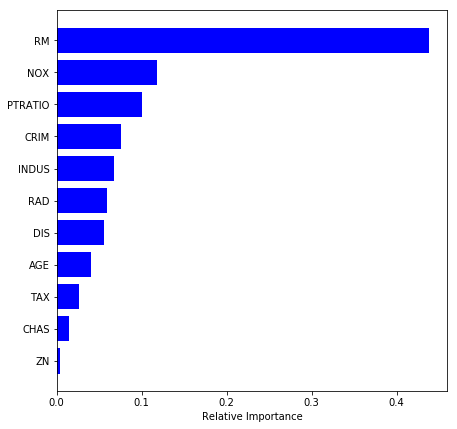

In [12]:
features = X_train.columns
importances = model_3_boston.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [13]:
def get_partial_dependence_2(res, feature, X, y):
    """
    The function takes in a fitted model, data and a feature of X and takes a sample of 50 feature values called grid and
    calculates partial dependence.The partial function tells us for given value(s) of feature what is the average 
    marginal effect on the model prediction
    """
    data = X.copy()
    grid = np.linspace(np.percentile(data.loc[:, feature], 0.1),
                       np.percentile(data.loc[:, feature], 99.5),
                    50)
    y_pred = np.zeros(50)
    for i, val in enumerate(grid):
                data.loc[:, feature] = val
                pred = res.predict(data)
                y_pred[i] = np.average(pred)
    
    return grid, y_pred

Text(0, 0.5, 'Prediction')

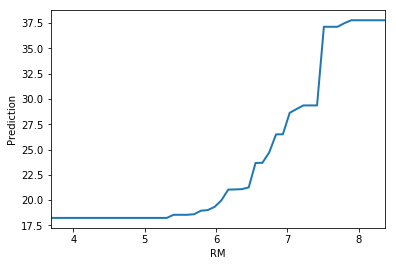

In [14]:
fig, ax = plt.subplots(1,1)
grid, y_pred_model_3 = get_partial_dependence_2(model_3_boston, 'RM', X_train, y_train)
axis = ax
axis.plot(grid, y_pred_model_3, linewidth = 2)
axis.set_xlim(min(grid), max(grid))
axis.set_xlabel('RM', fontsize = 10)
axis.set_ylabel('Prediction', fontsize = 10)

## USE CASE 2 REDUCE IMPORTANCE OF THE FEATURE

#### Restricted Model

In [15]:
X_train_case_3 = X_train.drop(columns=['RM'])
X_test_case_3 = X_test.drop(columns=['RM'])

param_grid['monotone_constraints'] =  ["(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)"]

model_4 = xgb.XGBRegressor()
gr = GridSearchCV(model_4,param_grid=param_grid,cv=5, verbose=True)
model_4_boston = gr.fit(X_train_case_3,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.0s finished


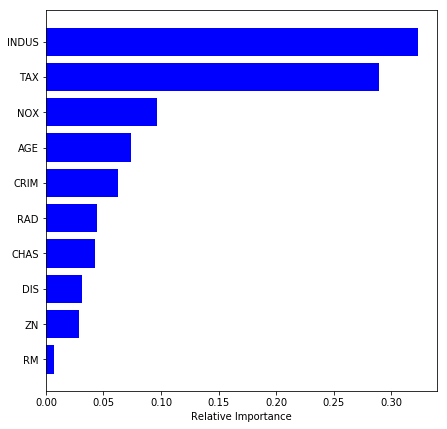

In [16]:
features = X_train.columns
importances = model_4_boston.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Mixing Models

In [17]:
final_data = pd.DataFrame({'RM' :grid, 
                          'y_pred_model_3': y_pred_model_3, 
                          'restricted_model': 22.5})

In [18]:
alpha_list = [1, 0.66, 0.33, 0]

for alpha in alpha_list: 
    final_data['y_blended_'+str(alpha)] = final_data['y_pred_model_3']*alpha + final_data['restricted_model']*(1-alpha)

In [19]:
final_data.head()

,RM,restricted_model,y_pred_model_3,y_blended_1,y_blended_0.66,y_blended_0.33,y_blended_0
0,3.682706,22.5,18.239117,18.239117,19.687817,21.093909,22.5
1,3.778443,22.5,18.239117,18.239117,19.687817,21.093909,22.5
2,3.874180,22.5,18.239117,18.239117,19.687817,21.093909,22.5
3,3.969918,22.5,18.239117,18.239117,19.687817,21.093909,22.5
4,4.065655,22.5,18.239117,18.239117,19.687817,21.093909,22.5


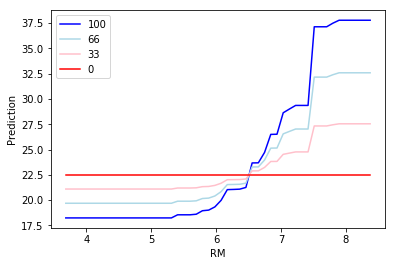

In [20]:
ax = sns.lineplot(data=final_data, x="RM", y="y_pred_model_3", color='blue')
ax = sns.lineplot(data=final_data, x="RM", y="y_blended_0.66", color='lightblue')
ax = sns.lineplot(data=final_data, x="RM", y="y_blended_0.33", color='pink')
ax = sns.lineplot(data=final_data, x="RM", y="restricted_model", color='red')
ax.legend(labels = ['100',  '66', '33','0'])
ax.set_xlabel('RM')
ax.set_ylabel('Prediction')
plt.show()

## USE CASE 3 - U SHAPE

In [21]:
df = pd.read_csv("californiaDDSDataV2.csv")
df = df.drop(columns = 'Id')
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


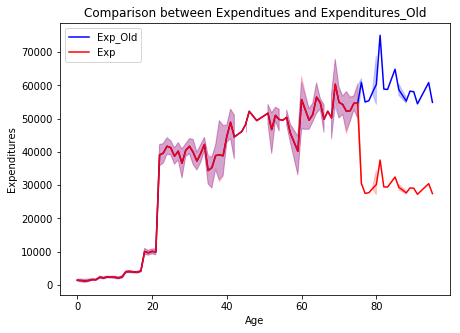

In [22]:
df['Expenditures_Old'] = df['Expenditures']
df.loc[df['Age']>75, 'Expenditures'] = df.loc[df['Age']>75, 'Expenditures']/2
df['Gender']= preprocessing.LabelEncoder().fit_transform(df['Gender']) 

f, ax = plt.subplots(1, 1)
f.set_size_inches(7, 5)
sns.lineplot(data=df, x="Age", y="Expenditures_Old", color='blue')
sns.lineplot(data=df, x="Age", y="Expenditures", color='red')
plt.title("Comparison between Expenditues and Expenditures_Old") 
plt.legend(labels=["Exp_Old","Exp"])
plt.savefig('images/Comparison between Expenditues and Expenditures_Old.png')
plt.show()

In [23]:
X = df[["Age", "Gender"]]
y = df["Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [24]:
param_grid = {
                'max_depth': [3], 
                'learning_rate': [.05], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [25, 30, 40, 50, 100, 150],
                'reg_gamma': [0.5]
}

In [25]:
xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid, cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


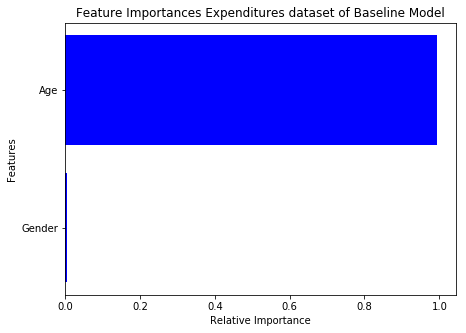

In [26]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset of Baseline Model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

### Adding monotone contraint on Age 

In [27]:
param_dict = param_grid
param_dict['monotone_constraints'] = ["(1,0)"]

In [28]:
xgbr_2 = xgb.XGBRegressor()
gr2 = GridSearchCV(xgbr_2,param_grid=param_dict,cv=5, verbose=True)
res2 = gr2.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [29]:
print_results(res2, X_train, y_train, X_test, y_test)

XGB Model best params : {'n_estimators': 100, 'random_state': 123, 'objective': 'reg:squarederror', 'reg_gamma': 0.5, 'max_depth': 3, 'monotone_constraints': '(1,0)', 'learning_rate': 0.05}
 Train RMSE: 4694.68000
 Test RMSE: 4796.06407


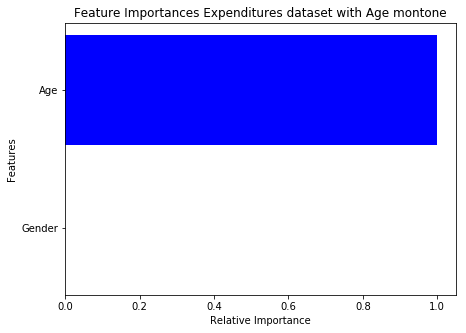

In [30]:
features = X_train.columns
importances = res2.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset with Age montone')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

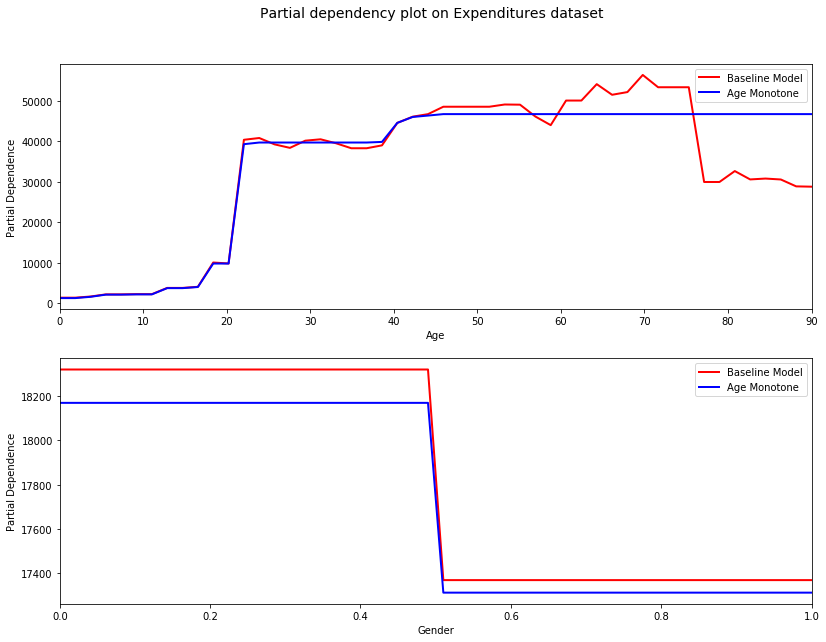

In [31]:
features = X_train.columns
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12, 10)
fig.suptitle('Partial dependency plot on Expenditures dataset', fontsize=14)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    grid2, y_pred2 = get_partial_dependence(res2, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2, label='Baseline Model')
    axis.plot(grid2, y_pred2, color = 'blue', linewidth = 2, label='Age Monotone')
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 10)
    axis.set_ylabel('Partial Dependence', fontsize = 10)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 10)
plt.show()

In [32]:
df['y_pred'] = res.predict(X)
df['y_pred2'] = res2.predict(X)

### Kink in Age

In [33]:
df['Age_plus'] = df['Age']
df.loc[df['Age']>75, 'Age_Plus'] = 75
df['Age_minus'] = df['Age']
df.loc[df['Age']<=75, 'Age_minus'] = 75
param_dict = param_grid
param_dict['monotone_constraints'] = ["(1,-1, 0)"]

In [34]:
X = df[["Age_plus", "Age_minus", "Gender"]]
y = df["Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)


xgbr_age_kink = xgb.XGBRegressor()
gr3 = GridSearchCV(xgbr_age_kink,param_grid=param_dict,cv=5, verbose=True)
age_kink_model = gr3.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.7s finished


In [35]:
df['y_pred3'] = age_kink_model.predict(X)

In [36]:
print_results(age_kink_model, X_train, y_train, X_test, y_test)

XGB Model best params : {'n_estimators': 150, 'random_state': 123, 'objective': 'reg:squarederror', 'reg_gamma': 0.5, 'max_depth': 3, 'monotone_constraints': '(1,-1, 0)', 'learning_rate': 0.05}
 Train RMSE: 3486.59878
 Test RMSE: 3272.34403


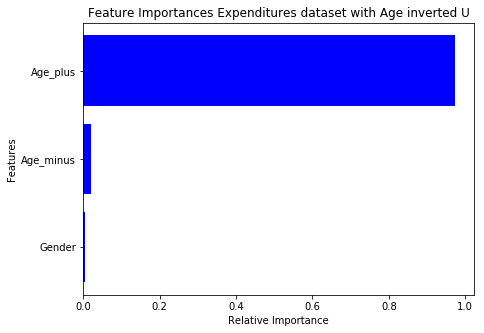

In [37]:
features = X_train.columns
importances = age_kink_model.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 5))
plt.title('Feature Importances Expenditures dataset with Age inverted U')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

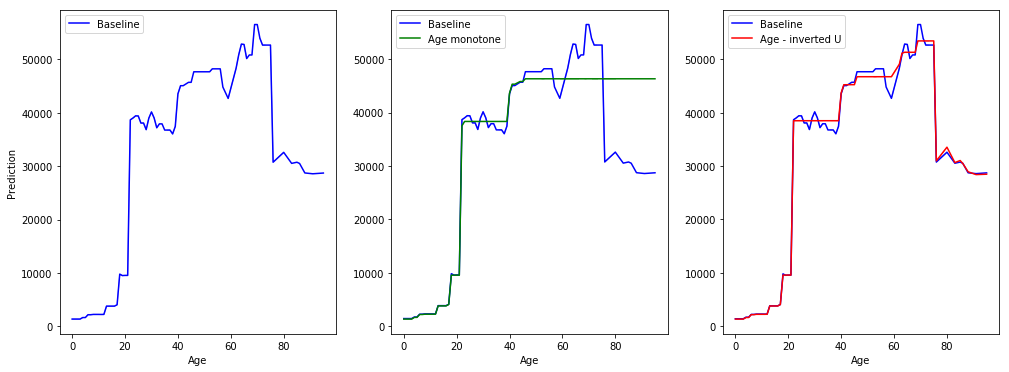

In [38]:
f, ax = plt.subplots(1, 3)
f.set_size_inches(15, 6)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
ax = ax.flatten()
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue', ax=ax[0])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Prediction')
ax[0].legend(labels = ['Baseline'])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue', ax = ax[1])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred2", color='green', ax = ax[1])
ax[1].set_xlabel('Age')
ax[1].set_ylabel('')
ax[1].legend(labels = ['Baseline', 'Age monotone'])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred", color='blue', ax = ax[2])
sns.lineplot(data=df[df["Gender"] == 1], x="Age", y="y_pred3", color='red', ax = ax[2])
ax[2].set_xlabel('Age')
ax[2].set_ylabel('')
ax[2].legend(labels = ['Baseline', 'Age - inverted U'])
plt.show()